In [7]:
!date

Mon Jul 26 11:05:10 PDT 2021


# Subclass DE isoform hidden by gene [GABA]

In [8]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [43]:
subclass_cmap = pd.read_csv('../../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [10]:
gene = anndata.read_h5ad("../../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../../data/notebook/revision/isoform.h5ad")

In [11]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [12]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [13]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [14]:
# restrict to a class

In [15]:
gene          = gene[gene.obs.class_label=="GABAergic"]
isoform = isoform[isoform.obs.class_label=="GABAergic"]

In [16]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.gene_name.values
assignments   = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

26-Jul-21 11:05:29 - 1 of 7 assignments: Lamp5
26-Jul-21 11:05:30 - 2 of 7 assignments: Meis2
26-Jul-21 11:05:31 - 3 of 7 assignments: Pvalb
26-Jul-21 11:05:32 - 4 of 7 assignments: Sncg
26-Jul-21 11:05:33 - 5 of 7 assignments: Sst
26-Jul-21 11:05:34 - 6 of 7 assignments: Sst Chodl
26-Jul-21 11:05:35 - 7 of 7 assignments: Vip


CPU times: user 5.8 s, sys: 4.01 s, total: 9.81 s
Wall time: 9.8 s


In [17]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
markers_isoform = markers_isoform.query("es > 0")

26-Jul-21 11:05:41 - 1 of 7 assignments: Lamp5
26-Jul-21 11:05:44 - 2 of 7 assignments: Meis2
26-Jul-21 11:05:46 - 3 of 7 assignments: Pvalb
26-Jul-21 11:05:48 - 4 of 7 assignments: Sncg
26-Jul-21 11:05:50 - 5 of 7 assignments: Sst
26-Jul-21 11:05:52 - 6 of 7 assignments: Sst Chodl
26-Jul-21 11:05:55 - 7 of 7 assignments: Vip


CPU times: user 9.65 s, sys: 11 s, total: 20.6 s
Wall time: 20.6 s


# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not for each subclass

In [18]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [19]:
setdiff.shape

(3723,)

In [20]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,index_name
441265,Sst Chodl,Aldoa-203_ENSMUST00000106348.8,5.09605e-32,1.7082e-28,3.25395,Sst Chodl_Aldoa
455293,Sst Chodl,Rcan2-202_ENSMUST00000044895.13,2.09064e-10,7.00784e-07,1.84448,Sst Chodl_Rcan2
359738,Sst,Aldoa-203_ENSMUST00000106348.8,6.37318e-94,1.7966e-90,1.7837,Sst_Aldoa
107085,Meis2,Snap25-202_ENSMUST00000110098.4,5.15494e-49,3.43835e-46,1.77256,Meis2_Snap25
420090,Sst Chodl,Meg3-201_ENSMUST00000124106.8,7.29151e-14,2.44411e-10,1.32368,Sst Chodl_Meg3
472007,Sst Chodl,Romo1-202_ENSMUST00000109597.10,1.82801e-06,0.00612748,1.26433,Sst Chodl_Romo1
421376,Sst Chodl,Anxa7-202_ENSMUST00000100844.6,5.39921e-07,0.00180982,1.19068,Sst Chodl_Anxa7
407850,Sst Chodl,Ccm2-201_ENSMUST00000000388.15,2.02823e-06,0.00679862,1.1395,Sst Chodl_Ccm2
419039,Sst Chodl,Nme2-202_ENSMUST00000072566.5,1.02172e-10,3.42479e-07,1.11926,Sst Chodl_Nme2
420854,Sst Chodl,Glrx-201_ENSMUST00000022082.8,1.60283e-07,0.00053727,1.07483,Sst Chodl_Glrx


In [33]:
specific_cluster = "Sst Chodl"
specific_isoform = "Aldoa-203_ENSMUST00000106348.8"
specific_gene = "".join(specific_isoform.split("-")[:-1])

In [34]:
specific_gene

'Aldoa'

In [35]:
gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

['Aldoa_ENSMUSG00000030695.17', 'Aldoa_ENSMUSG00000114515.3']
Categories (26154, object): ['5S_rRNA_ENSMUSG00000118681.1', '5S_rRNA_ENSMUSG00000118725.1', '5S_rRNA_ENSMUSG00000118727.1', '5S_rRNA_ENSMUSG00000118747.1', ..., 'n-R5s25_ENSMUSG00000064857.3', 'n-R5s41_ENSMUSG00000064959.3', 'n-R5s173_ENSMUSG00000064554.3', 'n-R5s185_ENSMUSG00000065887.2']

In [36]:
specific_gene = gene.var[gene.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]

In [37]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    ax.set_xticklabels(labels, rotation=45, ha="right")

    
    return ax


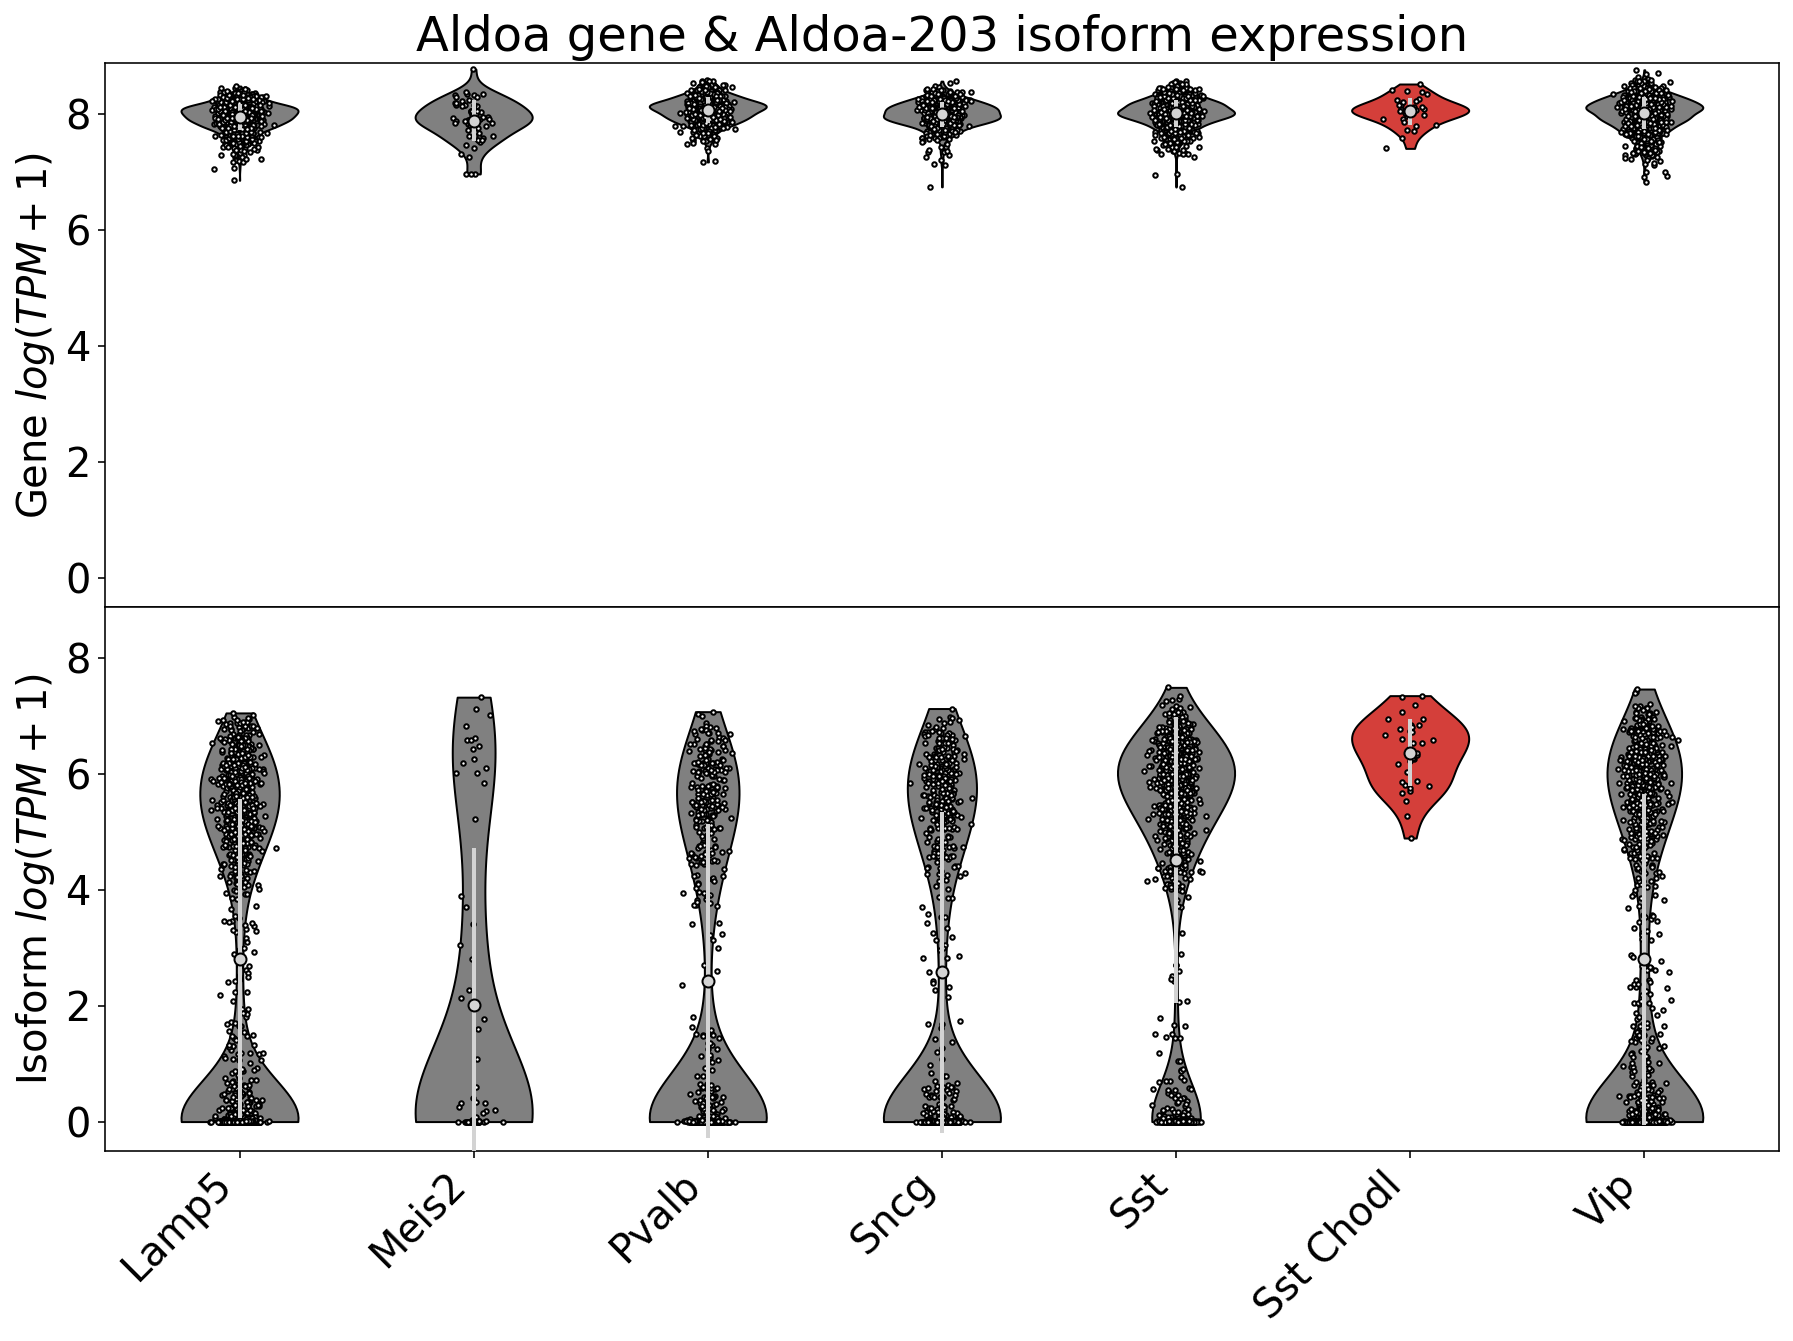

In [39]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)


######## Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.subclass_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)

ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",
    "ylim": -0.5

})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})

plt.savefig("../../../figures/subclass_DE_violin_{}-GABA.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

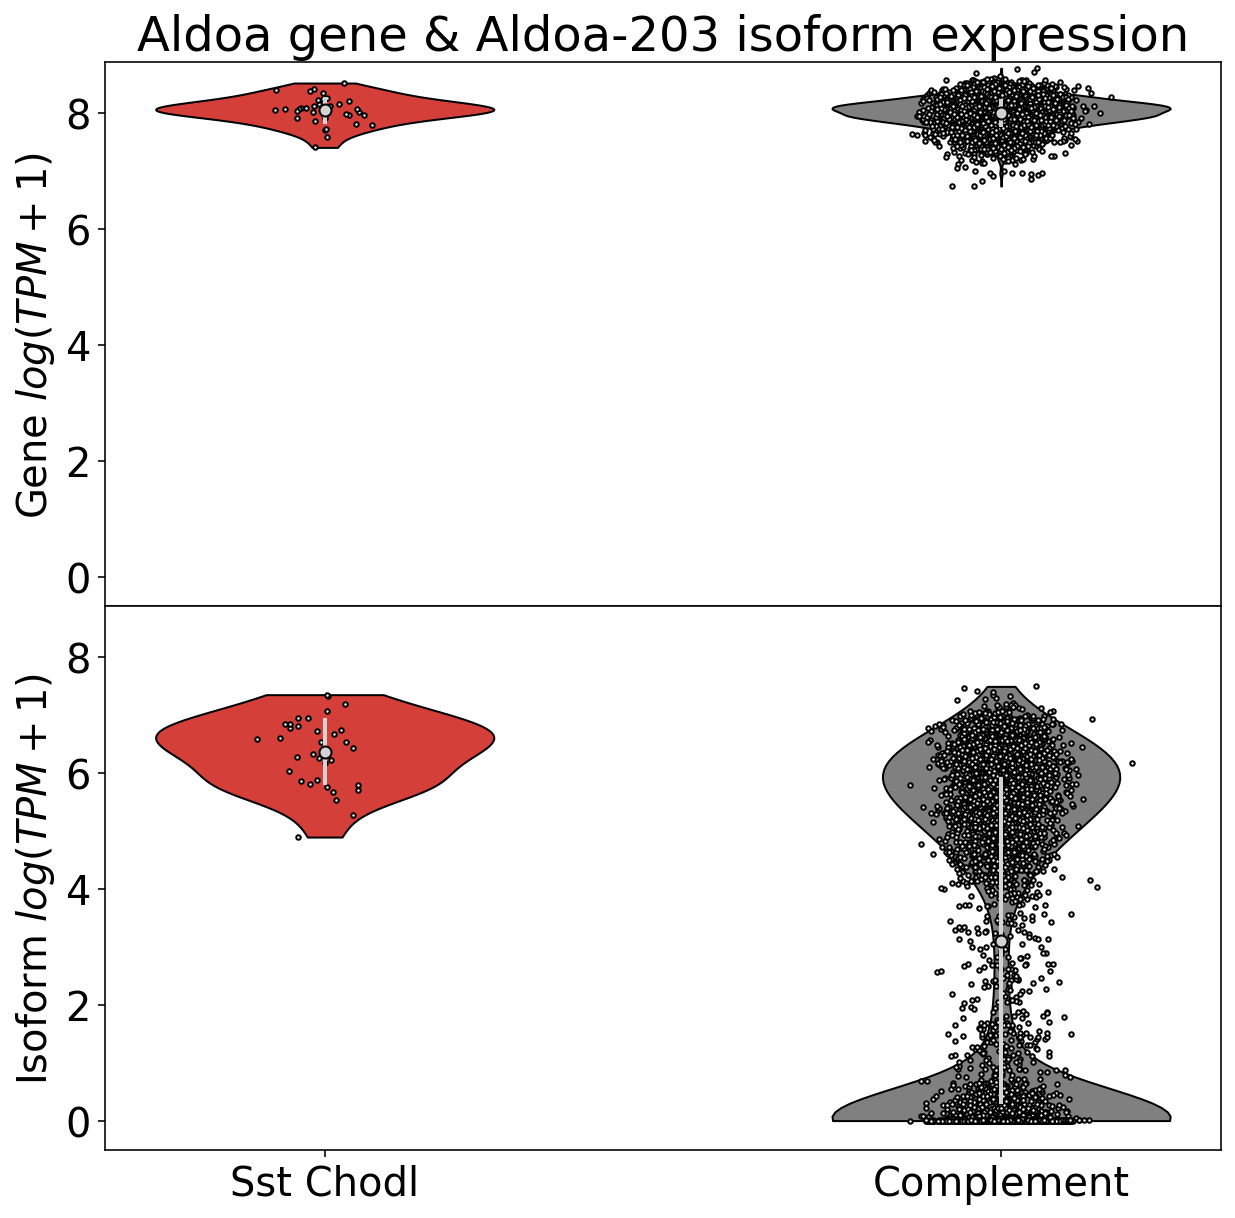

In [40]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.subclass_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
labels = [specific_cluster, "Complement"]
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

#######3# Gene
x = []
x.append(np.asarray(gene[gene.obs.subclass_label==specific_cluster][:,gene.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
x.append(np.asarray(gene[gene.obs.subclass_label!=specific_cluster][:,gene.var.gene_name.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=0)

#################### BAD GENE ####################
x = []

x.append(np.asarray(isoform[isoform.obs.subclass_label==specific_cluster][:,isoform.var.transcript_name.values==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())
x.append(np.asarray(isoform[isoform.obs.subclass_label!=specific_cluster][:,isoform.var.transcript_name.values==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=0, xticks=lidx, xticklabels=labels)


ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",
    "ylim": -0.5

})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})

ax[1].set_xticklabels(labels, rotation=0, ha="center")


plt.show()

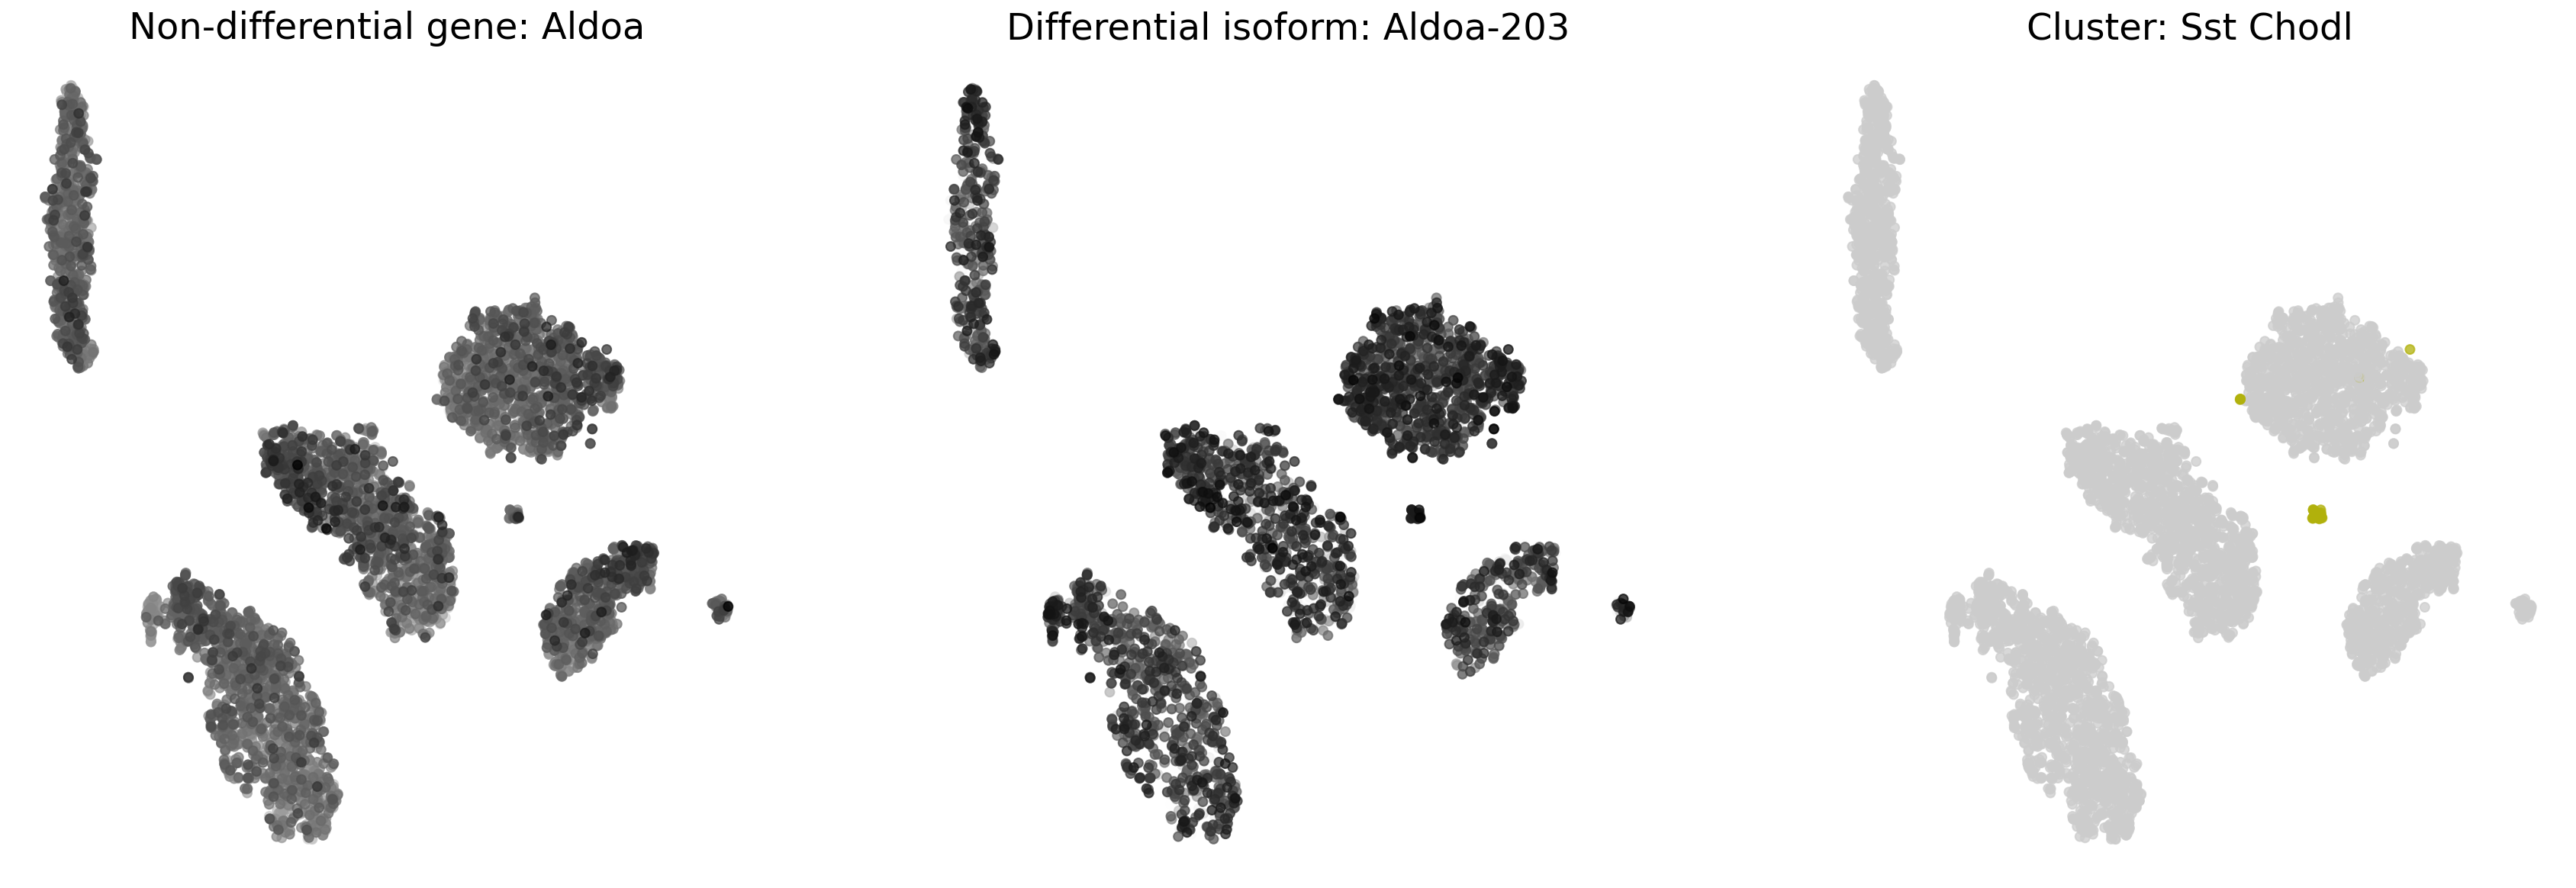

In [44]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(gene.obs["subclass_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
    
c = np.array(c)
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster.split("_")[0]))
#plt.savefig(trackfig("../../figures/subclass_DE_nca_{}-GABA.png".format(specific_gene.split("_")[0]), TRACKFIG, NB), bbox_inches='tight',dpi=300)
plt.show()

In [45]:
identified_isoforms = markers_isoform["name"].explode().astype(str)
identified_isoforms = identified_isoforms[identified_isoforms!="nan"]

In [47]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0])

In [48]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

381 isoforms from 324 genes identified.


In [50]:
markers_isoform.to_csv("../../../tables/unordered/subclass_DE-GABA.csv")

In [51]:
markers_isoform[markers_isoform.name.str.contains("Nrxn")]

,index,name,p_raw,p_corr,es,index_name
262695,Sncg,Nrxn1-225_ENSMUST00000197268.5,4.21568e-08,0.000135998,0.216775,Sncg_Nrxn1
